### Imports, mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/SEB_task_portfolio/'
print('\nFiles:')
!dir

from function import *
import scipy.stats as stats
from sklearn import preprocessing

r = 0.002

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SEB_task_portfolio

Files:
function.py  portfolio_analysis.ipynb  __pycache__  Test_candidates.xlsx


### Data

In [2]:
data, portfolio = load_data('Test_candidates.xlsx')
display(data.head(3))
print()
display(portfolio.head(3))

,IMPL VOL Apple,Price Apple,IMPL VOL Amazon,Price Amazon,IMPL VOL Google,Price Google
Date,,,,,,
2010-06-01,0.4497,257.04,0.5118,123.24,0.4100,482.37
2010-06-02,0.4326,260.11,0.4668,126.31,0.3811,493.37
2010-06-03,0.4029,259.29,0.4558,128.76,0.3579,505.60


,Instrument,Company,Position,Strike,Tenor*
0,Shares,Google,300,NaN,NaN
1,Put,Google,300,700,1 month
2,Call,Google,-300,850,1 month


# Question 1: 

## What was the portfolio value on the 19th April 2013?

In [4]:
date='2013-04-17'
portfolio_value_2013_04_19 = np.round(portfolio_value(date=date, stock_data=data, portfolio_data=portfolio, r=r), 2)
print('Portfolio value on {} is {}'.format(date, portfolio_value_2013_04_19))

Portfolio value on 2013-04-17 is 187208.82


## To which risk factors is the portfolio most sensitive?

### Correlation

In [5]:
ml_greeks = ml_greeks(stock_data=data, portfolio_data=portfolio, r=r)
ml_greeks.head(3)

,IMPL VOL Apple,Price Apple,IMPL VOL Amazon,Price Amazon,IMPL VOL Google,Price Google,Delta,Gamma,Theta,Vega,Rho,Value
Date,,,,,,,,,,,,
2010-06-01,1.986309,-1.355665,1.625461,-1.913513,2.041820,-1.425069,-1.078726,-1.042657,0.984350,-1.038539,-1.030448,211903.573715
2010-06-02,1.705458,-1.330806,1.033470,-1.838365,1.541930,-1.300151,-1.078924,-1.043957,0.986822,-1.039813,-1.030575,210674.385099
2010-06-03,1.217664,-1.337445,0.888761,-1.778393,1.140635,-1.161266,-1.079454,-1.049961,0.991143,-1.042551,-1.030828,210346.978834


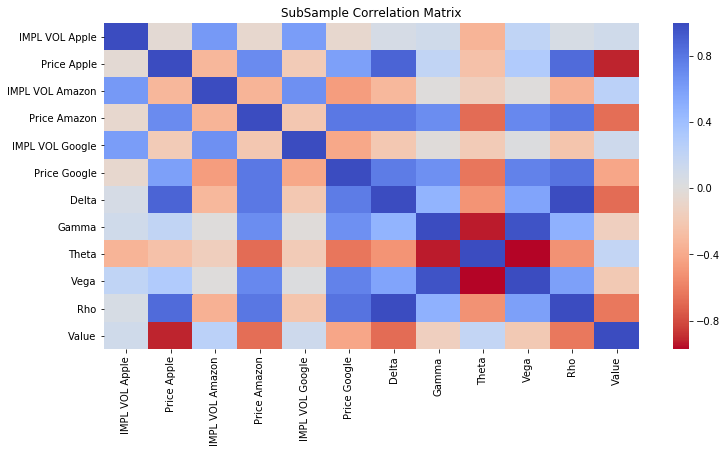

In [6]:
corr = ml_greeks.corr()
plt.figure(figsize=(12,6))
sns.heatmap(data=corr, cmap='coolwarm_r')
plt.title('SubSample Correlation Matrix')
plt.show()

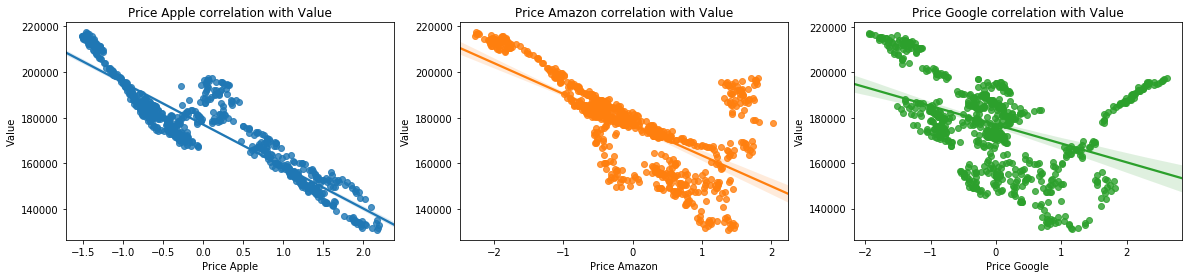

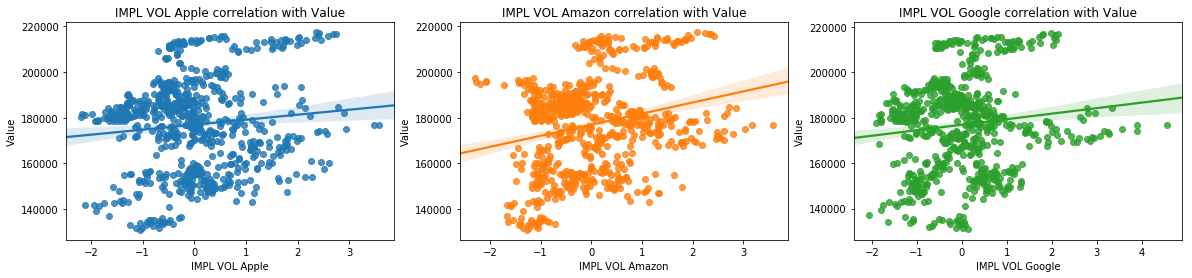

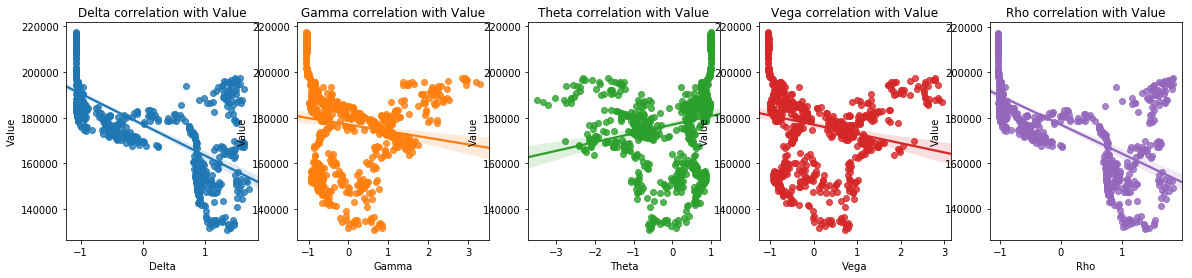

In [7]:
plot_correlations(x=['Price Apple', 'Price Amazon', 'Price Google'], y='Value', data=ml_greeks, figsize=(20,4))
plot_correlations(x=['IMPL VOL Apple', 'IMPL VOL Amazon', 'IMPL VOL Google'], y='Value', data=ml_greeks, figsize=(20,4))
plot_correlations(x=['Delta', 'Gamma', 'Theta', 'Vega', 'Rho'], y='Value', data=ml_greeks, figsize=(20,4))

### Logistic regression

In [0]:
portfolio_over_time = portfolio_values_over_time(stock_data=data, portfolio_data=portfolio)
Y_train = portfolio_over_time.values

#### Training Greeks

In [9]:
X_train_greeks = ml_greeks[['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']].values

model_greeks = LinearRegression()
model_greeks.fit(X_train_greeks, Y_train)

coeficients_greeks = np.abs(np.around(model_greeks.coef_, 3))

print('Delta coff: {}'.format(coeficients_greeks[0][0]))
print('Gamma coff: {}'.format(coeficients_greeks[0][1]))
print('Theta coff: {}'.format(coeficients_greeks[0][2]))
print('Vega coff: {}'.format(coeficients_greeks[0][3]))
print('Rho coff: {}'.format(coeficients_greeks[0][4]))

Delta coff: 107421.24
Gamma coff: 2271.738
Theta coff: 4480.804
Vega coff: 666.952
Rho coff: 92645.88


#### Training price and volatility

In [10]:
X_train_factors = ml_greeks[['IMPL VOL Apple', 'Price Apple', 'IMPL VOL Amazon', 'Price Amazon', 'IMPL VOL Google', 'Price Google']].values

model_factors = LinearRegression()
model_factors.fit(X_train_factors, Y_train)

coeficients_factors = np.abs(np.around(model_factors.coef_, 3))

print('apple_vol coff: {}'.format(coeficients_factors[0][0]))
print('apple_price coff: {}'.format(coeficients_factors[0][1]))
print('amazon_vol coff: {}'.format(coeficients_factors[0][2]))
print('amazon_price coff: {}'.format(coeficients_factors[0][3]))
print('google_vol coff: {}'.format(coeficients_factors[0][4]))
print('google_price coff: {}'.format(coeficients_factors[0][5]))

apple_vol coff: 2342.936
apple_price coff: 18524.378
amazon_vol coff: 1727.295
amazon_price coff: 7053.215
google_vol coff: 510.063
google_price coff: 7912.861


### Answer

Based on Linear Regression model coeficients, biggest impact has Stock prices and interest rate.  
Biggest absolute values of coeficients are for price feature and secondly for interest rate feature. 
Also by looking on correlations we can clearly notice that stock prices negatively correlates with final portfolio value more agressively than volatilities correlates (because of the fitted regression line steaps). Using logistic regression model we can even notice that Apple stock price is a risk feature to which model correlates most - most sensitive for it (logistic regression model coeficient absolute value is the bisggest: 19110.761), secondly comes Google stock price (8900.314), then amazon stock price (6606.575), apple volatility (2320.563), amazon volatility (1506.095) and lastly google volatility (605.732). Talking about Greek factors from correlation map we can quicly notice that Delta and Rho are two Greek parameters which positivelly correlates with portfolio value where Rho represents how interest rate changes affects final value what means that other risk factor - interest rate is important risk parameter to this specific portfolio as well (in correlation maps Delta is most Red for Value, then a bit lighter red comes with Rho on Value, values with logistic regression - Delta: 110477.688, Rho: 95840.279  --> and it matches with correlation map conclusions).

# Question 2:  

## At which date would the portfolio suffer the largest loss?

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


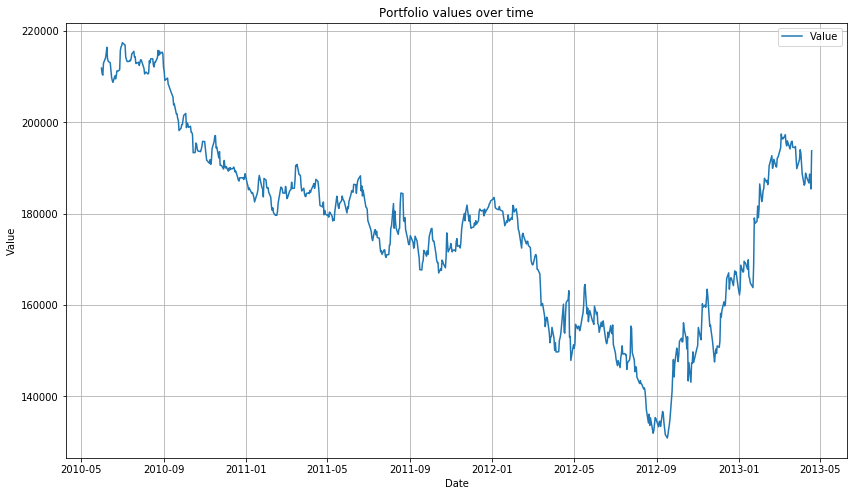

In [11]:
portfolio_over_time = portfolio_values_over_time(stock_data=data, portfolio_data=portfolio)
plt.figure(figsize=(14,8))
sns.lineplot(data=portfolio_over_time)
plt.title('Portfolio values over time')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [12]:
min_value = portfolio_over_time.min().values[0]
min_value_date = portfolio_over_time.loc[portfolio_over_time['Value'] == min_value].index[0]

print('Date when portfolio value was lowest is: {}'.format(min_value_date))

Date when portfolio value was lowest is: 2012-09-17 00:00:00


## How much did the risk factor move on that date?

**Notice** that in data there is no entry of day 2012-09-16, first entry before maximum loss day is 2012-09-14!

In [13]:
portfolio_value_min1 = portfolio_value(date='2012-09-14', stock_data=data, portfolio_data=portfolio, r=r)
greeks_list1 = portfolio_greeks(date='2012-09-14', stock_data=data, portfolio_data=portfolio, r=r)

portfolio_value_min2 = portfolio_value(date=min_value_date, stock_data=data, portfolio_data=portfolio, r=r)
greeks_list2 = portfolio_greeks(date=min_value_date, stock_data=data, portfolio_data=portfolio, r=r)

print('Portfolio value on {} is {}'.format('2012-09-14 00:00:00', portfolio_value_min1))
print('Portfolio value on {} is {}'.format(min_value_date, portfolio_value_min2))

Portfolio value on 2012-09-14 00:00:00 is 131282.18966290174
Portfolio value on 2012-09-17 00:00:00 is 130522.34257841417


In [14]:
greeks_df1 = pd.DataFrame(greeks_list1, columns=['Delta', 'Gamma', 'Theta', 'Vega', 'Rho'])
greeks_df2 = pd.DataFrame(greeks_list2, columns=['Delta', 'Gamma', 'Theta', 'Vega', 'Rho'])

greeks_df1_mean = greeks_df1.mean()
greeks_df2_mean = greeks_df2.mean()

comparison_df = pd.DataFrame(greeks_df1_mean, columns=['2012-09-14'])
comparison_df.insert(loc=1, column='2012-09-17', value=greeks_df2_mean)
display(comparison_df)
print('\nDifferences: ')
display(comparison_df['2012-09-14']-comparison_df['2012-09-17'])

,2012-09-14,2012-09-17
Delta,0.430881,0.424542
Gamma,0.002874,0.002568
Theta,-23.006658,-23.201639
Vega,13.242460,12.901734
Rho,5.609015,5.479965



Differences: 


Delta    0.006339
Gamma    0.000307
Theta    0.194981
Vega     0.340726
Rho      0.129050
dtype: float64

# Question 3

## What would be variance-covariance Value at Risk of the portfolio for 1 day horizon and confidence interval: 99%?


In [15]:
portfolio_over_time = portfolio_values_over_time(stock_data=data, portfolio_data=portfolio)
portfolio_changes = calc_portfolio_changes(portfolio_over_time)
values_and_changes = portfolio_over_time.copy()
values_and_changes['Changes'] = portfolio_changes
display(values_and_changes.head())

portfolio_changes.sort()

,Value,Changes
2010-06-01,211903.573715,0.000000
2010-06-02,210674.385099,-0.583454
2010-06-03,210346.978834,-0.155651
2010-06-04,212959.759491,1.226889
2010-06-07,214100.512877,0.532812


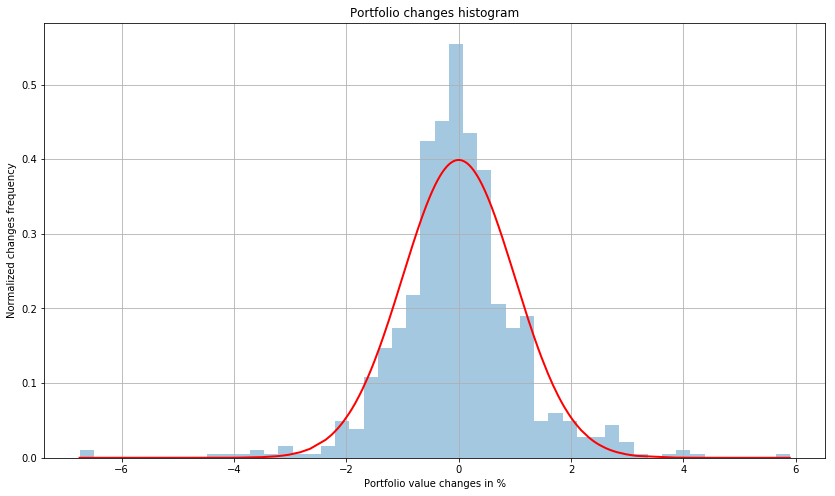

In [16]:
norm_array = stats.norm.pdf(portfolio_changes) 
plt.figure(figsize=(14,8))
ax = sns.distplot(a=portfolio_changes, kde=False, norm_hist=True)
plt.grid()
plt.ylabel('Normalized changes frequency')
plt.xlabel('Portfolio value changes in %')
plt.title('Portfolio changes histogram')
ax.plot(portfolio_changes, norm_array, 'r', lw=2)
plt.show()

In [17]:
std = np.std(portfolio_changes)
vc_var = np.round(- 2.33*std, 3)

print('Variance-covariance VaR for 1 day horizon and confidence interval equal to 99% is {} %'.format(vc_var))

Variance-covariance VaR for 1 day horizon and confidence interval equal to 99% is -2.669 %


# Question 4

## What would be historical simulation Value at Risk of the portfolio for 1 day horizon and confidence interval: 99%?


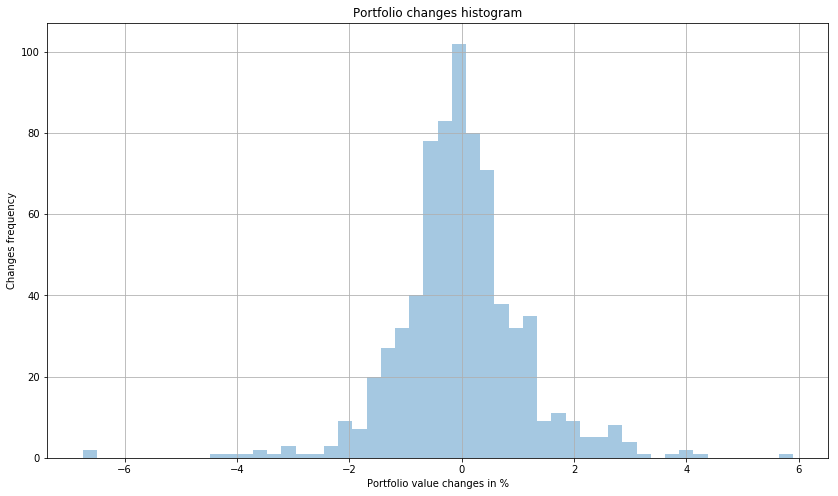

In [18]:
plt.figure(figsize=(14,8))
sns.distplot(a=portfolio_changes, kde=False, label='Actual portfolio value changes')
plt.grid()
plt.ylabel('Changes frequency')
plt.xlabel('Portfolio value changes in %')
plt.title('Portfolio changes histogram')
plt.show()

In [19]:
hist_var = np.round(var_historical(confident=99, df=portfolio_over_time),3)

print('Historical VaR for 1 day horizon and confidence interval equal to 99% is {} %'.format(hist_var))

Historical VaR for 1 day horizon and confidence interval equal to 99% is -3.235 %


# Question 5

## How would you test if variance-covaraince VaR is adequatelly measuring the risk? 

I would need to test a model on amount of data with expectations to get losses equal or bigger than -2.669 % on  
`amount_of_data*0.01` examples if `confident == 99%`.

## Is the model performance acceptable?


In [20]:
portfolio_over_time = portfolio_values_over_time(stock_data=data, portfolio_data=portfolio)
portfolio_changes = calc_portfolio_changes(portfolio_over_time)

test_VaR(portfolio_changes=portfolio_changes, vc_VaR=vc_var)

Total: 727
Correct: 12
Fraction: 2.0%


No, models performance is not acceptable because fraction of losses bigger than -2.669 is 2% when we expected to get around 1% because of confident level we choosed (99%).